In [2]:
from evaluate import translate_sentence, load_model
import torch
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import ticker

In [3]:
class Evaluation:
    def __init__(self, device, checkpoint_path):
        self.device = device
        print('Loading Checkpoint ...')
        checkpoint = torch.load(checkpoint_path, map_location=device)
        print('Loading Model...')
        self.model = load_model(checkpoint, device)
        print('Loading Vocabulary...')
        self.source_stoi = checkpoint['source_stoi']
        self.source_itos = checkpoint['source_itos']
        self.target_stoi = checkpoint['target_stoi']
        self.target_itos = checkpoint['target_itos']
    
                 
    def predict(self, factor: str, attention_maps = True):

        expansion = translate_sentence(factor, self.source_stoi, self.source_itos, self.target_stoi,
                                               self.target_itos, self.model, self.device, attention_maps = attention_maps ,max_len = 30)
        return expansion
    
    
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

checkpoint_path = 'checkpoints/checkpoint_test_time.pt'
    
evaluation = Evaluation(device, checkpoint_path)

Loading Checkpoint ...
Loading Model...
Loading Vocabulary...


In [4]:
def display_attention(sentence, translation, attention, n_heads = 4, n_rows = 2, n_cols = 2):
    
    assert n_rows * n_cols == n_heads
    
    fig = plt.figure(figsize=(15,25))
    
    for i in range(n_heads):
        
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='Blues')

        ax.tick_params(labelsize=14)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                           rotation=45)
        ax.set_yticklabels(['']+translation)#+['<eos>'])

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

/tmp/ipykernel_73003/2166099437.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],
/tmp/ipykernel_73003/2166099437.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+translation)#+['<eos>'])


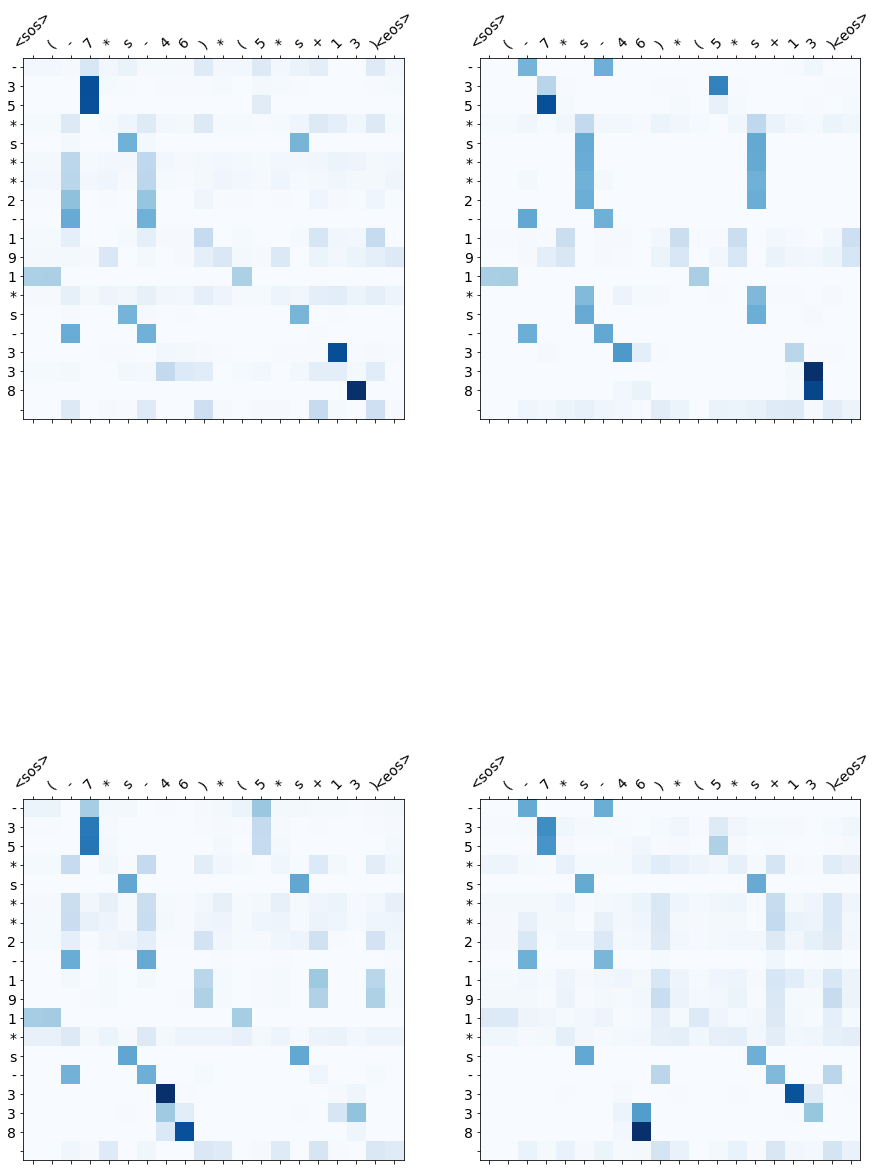

In [5]:
sent1 = '(-7*s-46)*(5*s+13)'
src, translation, attention = evaluation.predict(sent1)

display_attention(src, translation, attention)

### Predict on One Sentence
* ToDo => write code to predict on Batch 

In [9]:
import pandas as pd
from tqdm import tqdm
df= pd.read_csv('val.txt', sep = '=', header = None)
df.columns = ['factors', 'expressions']

In [17]:
c = 0
df = df.sample(frac=1).reset_index(drop=True)
for i in tqdm(range(len(df)), total = len(df)):
    actual = df.loc[i, 'expressions']
    pred = evaluation.predict(df.loc[i, 'factors'], attention_maps = False)
    if actual == pred:
        c+=1
    if (i+1)%1000==0: 
        print(f'Accuracy: {c / (i+1)}')

In [13]:
c / (i+1)

0.9967006598680264